# Pre-Process PadChest Dataset

In [1]:
from fastai.basics import *
import warnings
warnings.filterwarnings('ignore')
path = Path('/home/jupyter/data/padchest')

In [2]:
df = pd.read_csv(path/'PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160861 entries, 0 to 160860
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       160861 non-null  int64  
 1   ImageID                          160861 non-null  object 
 2   ImageDir                         160861 non-null  int64  
 3   StudyDate_DICOM                  160861 non-null  int64  
 4   StudyID                          160861 non-null  object 
 5   PatientID                        160861 non-null  object 
 6   PatientBirth                     160855 non-null  float64
 7   PatientSex_DICOM                 160857 non-null  object 
 8   ViewPosition_DICOM               91776 non-null   object 
 9   Projection                       160861 non-null  object 
 10  MethodProjection                 160861 non-null  object 
 11  Pediatric                        160861 non-null  object 
 12  Mo

In [3]:
# add a column for each label
df["Atelectasis"] = ""
df['Atelectasis'] = np.where(df['Labels'].str.contains('atelectasis'), 1, 0)
df["Cardiomegaly"] = ""
df['Cardiomegaly'] = np.where(df['Labels'].str.contains('cardiomegaly'), 1, 0)
df["Consolidation"] = ""
df['Consolidation'] = np.where(df['Labels'].str.contains('consolidation'), 1, 0)
df["Edema"] = ""
df['Edema'] = np.where(df['Labels'].str.contains('edema'), 1, 0)
df["Fracture"] = ""
df['Fracture'] = np.where(df['Labels'].str.contains('fracture'), 1, 0)
df["No Finding"] = ""
df['No Finding'] = np.where(df['Labels'].str.contains('normal'), 1, 0)
df["Pleural Effusion"] = ""
df['Pleural Effusion'] = np.where(df['Labels'].str.contains('pleural effusion'), 1, 0)
df["Pneumonia"] = ""
df['Pneumonia'] = np.where(df['Labels'].str.contains('pneumonia'), 1, 0)
df["Pneumothorax"] = ""
df['Pneumothorax'] = np.where(df['Labels'].str.contains('pneumothorax'), 1, 0)
# add a column to split dataset (test on manually labeled dataset)
df["is_valid"] = ""
df['is_valid'] = np.where(df['MethodLabel'].str.contains('Physician'), True, False)
# drop rows where all labels are negative 
df = df.drop(df[((df['Atelectasis'] == 0) & (df['Cardiomegaly'] == 0) &  (df['Consolidation'] == 0)
                    & (df['Edema'] == 0) & (df['Fracture'] == 0) & (df['No Finding'] == 0) 
                    & (df['Pleural Effusion'] == 0) & (df['Pneumonia'] == 0) & (df['Pneumothorax'] == 0))].index)
# drop empty reports
df = df.dropna(subset = ["Report"])
# drop duplicate reports 
df = df.drop_duplicates(subset = ["Report"])
# drop unused columns 
df = df.drop(["Unnamed: 0","ImageDir", "StudyDate_DICOM", "StudyID", "PatientID", 
              "PatientBirth", "MethodProjection", "PatientSex_DICOM", "ViewPosition_DICOM", "Projection", 
              "Pediatric", "Modality_DICOM", "Manufacturer_DICOM", "PhotometricInterpretation_DICOM", "PixelRepresentation_DICOM", 
              "PixelAspectRatio_DICOM", "SpatialResolution_DICOM", "BitsStored_DICOM", "Rows_DICOM", "Columns_DICOM", 
              "XRayTubeCurrent_DICOM", "Exposure_DICOM", "ExposureInuAs_DICOM", "BitsStored_DICOM", "WindowCenter_DICOM",
              "WindowWidth_DICOM", "SpatialResolution_DICOM", "ExposureTime", "RelativeXRayExposure_DICOM", "ReportID", 
              "MethodLabel", "Labels", "Localizations", "LabelsLocalizationsBySentence", "labelCUIS", 
              "LocalizationsCUIS"], axis=1)
# save labels dataframe
df.to_csv(path/"labels.csv", index=False, encoding='utf-8-sig')
df_labels = pd.read_csv(path/'labels.csv')
print (df_labels.info())
print (df['is_valid'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29365 entries, 0 to 29364
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ImageID           29365 non-null  object
 1   Report            29365 non-null  object
 2   Atelectasis       29365 non-null  int64 
 3   Cardiomegaly      29365 non-null  int64 
 4   Consolidation     29365 non-null  int64 
 5   Edema             29365 non-null  int64 
 6   Fracture          29365 non-null  int64 
 7   No Finding        29365 non-null  int64 
 8   Pleural Effusion  29365 non-null  int64 
 9   Pneumonia         29365 non-null  int64 
 10  Pneumothorax      29365 non-null  int64 
 11  is_valid          29365 non-null  bool  
dtypes: bool(1), int64(9), object(2)
memory usage: 2.5+ MB
None
False    22275
True      7090
Name: is_valid, dtype: int64


# 1. df for language model 

In [4]:
# drop unused columns
df_lm = df.drop(["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", 
                 "Fracture", "No Finding", "Pleural Effusion", "Pneumonia", 
                 "Pneumothorax", "is_valid"], axis=1)
df_lm.to_csv(path/"lm.csv", index=False, encoding='utf-8-sig')
df_lm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29365 entries, 0 to 160836
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageID  29365 non-null  object
 1   Report   29365 non-null  object
dtypes: object(2)
memory usage: 688.2+ KB


# 2. df for train & test

## df_train

In [5]:
df_train = df[df.is_valid == False]
df_train.to_csv(path/"train.csv", index=False, encoding='utf-8-sig')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22275 entries, 39061 to 160836
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ImageID           22275 non-null  object
 1   Report            22275 non-null  object
 2   Atelectasis       22275 non-null  int64 
 3   Cardiomegaly      22275 non-null  int64 
 4   Consolidation     22275 non-null  int64 
 5   Edema             22275 non-null  int64 
 6   Fracture          22275 non-null  int64 
 7   No Finding        22275 non-null  int64 
 8   Pleural Effusion  22275 non-null  int64 
 9   Pneumonia         22275 non-null  int64 
 10  Pneumothorax      22275 non-null  int64 
 11  is_valid          22275 non-null  bool  
dtypes: bool(1), int64(9), object(2)
memory usage: 2.1+ MB


In [6]:
df_train['Atelectasis'].value_counts()

0    17874
1     4401
Name: Atelectasis, dtype: int64

# df_test

In [7]:
df_test = df_labels[df_labels.is_valid == True]
df_test.to_csv(path/"test.csv", index=False, encoding='utf-8-sig')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7090 entries, 0 to 7089
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ImageID           7090 non-null   object
 1   Report            7090 non-null   object
 2   Atelectasis       7090 non-null   int64 
 3   Cardiomegaly      7090 non-null   int64 
 4   Consolidation     7090 non-null   int64 
 5   Edema             7090 non-null   int64 
 6   Fracture          7090 non-null   int64 
 7   No Finding        7090 non-null   int64 
 8   Pleural Effusion  7090 non-null   int64 
 9   Pneumonia         7090 non-null   int64 
 10  Pneumothorax      7090 non-null   int64 
 11  is_valid          7090 non-null   bool  
dtypes: bool(1), int64(9), object(2)
memory usage: 671.6+ KB


# 3. look at the data

In [8]:
df_labels.head()

,ImageID,Report,Atelectasis,Cardiomegaly,Consolidation,Edema,Fracture,No Finding,Pleural Effusion,Pneumonia,Pneumothorax,is_valid
0,20536686640136348236148679891455886468_k6ga29.png,sin hallazg patolog edad pacient .,0,0,0,0,0,1,0,0,0,True
1,3137231742710829928-247610802266403640553_km0qf9.png,radiografi actual comp con previ 26 juni persistent derram pleural derech . pequen atelectasi subsegmentari bas izquierd . sutur cerclaj esternotomi medi . engros pleural apical izquierd .,1,0,0,0,0,0,1,0,0,True
2,313723174271082992847610802266403640553-2_40kxq3.png,derram pleural bilateral predomini derech . pequen infiltr interstici alveolar parch bilateral ambos hemitorax . tub endotraqueal 5 mm carin . cerclaj esternotomi medi . sin grand cambi con respect estudi previ ayer .,0,0,0,0,0,0,1,0,0,True
3,313723174271082992847610802266403640553_w8dk8c.png,derram pleural bilateral predomini derech . pequen infiltr parch ambos hemitorax . tub endotraqueal . cerclaj esternotomi medi .,0,0,0,0,0,0,1,0,0,True
4,313723174271082992847610802266403640553_5_2icww3.png,sutur esternotomi medi . elevacion hemidiafragm izquierd present estudi previ . pers derram pleural bilateral mayor cuanti derech . liger infiltr perihili bibasal valor icc .,0,0,0,0,0,0,1,0,0,True


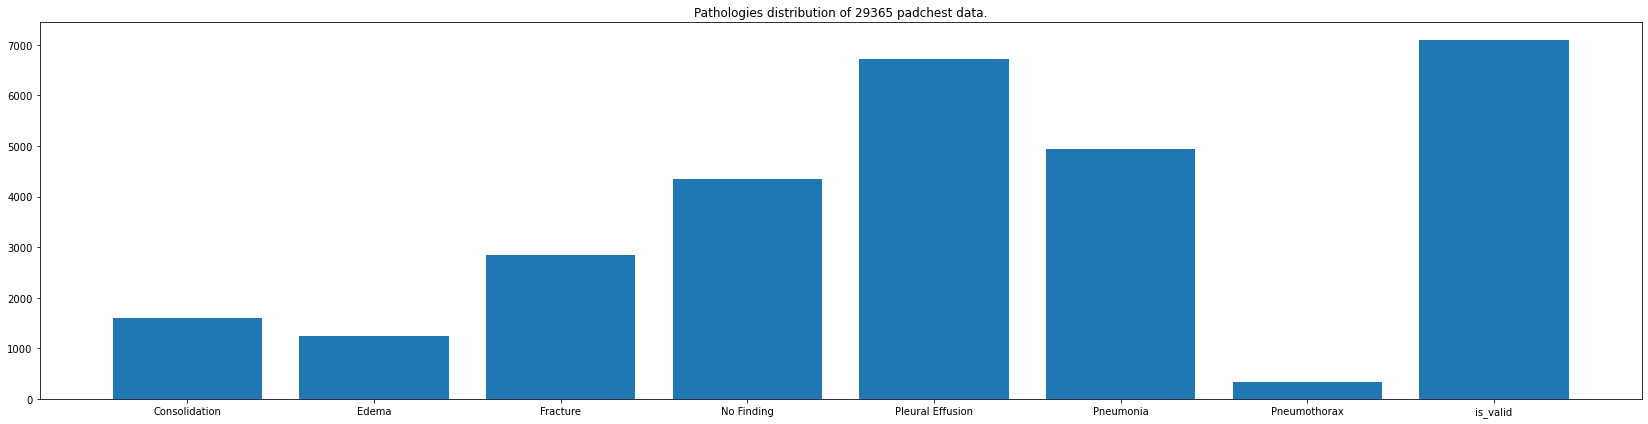

In [9]:
# look at the distribution of pathologies
f = lambda x: df_labels[x].sum()

path_types = df_labels.columns[4:13]
path_counts = [f(x) for x in path_types]

fig, ax = plt.subplots(1, 1, figsize = (23, 6))
plt.bar(path_types, path_counts)
ax.set_title(f"Pathologies distribution of {len(df_labels)} padchest data.")
plt.tight_layout();

In [10]:
df_labels.describe()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Fracture,No Finding,Pleural Effusion,Pneumonia,Pneumothorax
count,29365.000000,29365.000000,29365.000000,29365.000000,29365.000000,29365.000000,29365.000000,29365.000000,29365.000000
mean,0.199966,0.279176,0.054555,0.042227,0.097122,0.147965,0.228605,0.168159,0.011647
std,0.399981,0.448602,0.227113,0.201110,0.296129,0.355072,0.419942,0.374014,0.107291
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

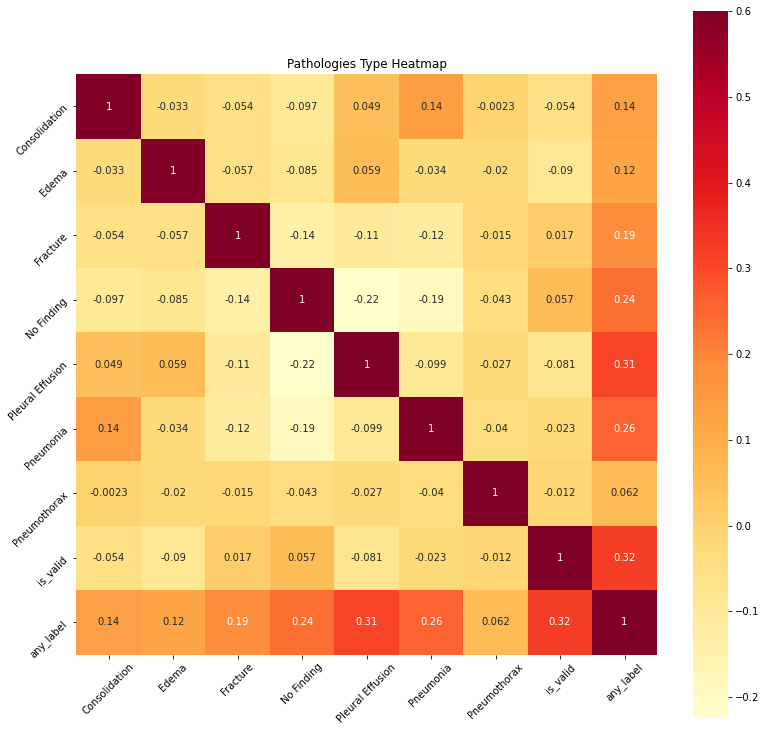

Pathologies Breakdown
=====

22161 out of 29365 pathology, or 75.47%, are classified as positive.

1602 Consolidation pathology. (5.46% of all data.)
- 23 or 1.44% were also Edema.
- 48 or 3.00% were also Fracture.
- 7 or 0.44% were also No Finding.
- 504 or 31.46% were also Pleural Effusion.
- 620 or 38.70% were also Pneumonia.
- 17 or 1.06% were also Pneumothorax.
- 232 or 14.48% were also is_valid.
- 1602 or 100.00% were also any_label.

1240 Edema pathology. (4.22% of all data.)
- 23 or 1.85% were also Consolidation.
- 20 or 1.61% were also Fracture.
- 5 or 0.40% were also No Finding.
- 429 or 34.60% were also Pleural Effusion.
- 134 or 10.81% were also Pneumonia.
- 2 or 0.16% were also Pneumothorax.
- 71 or 5.73% were also is_valid.
- 1240 or 100.00% were also any_label.

2852 Fracture pathology. (9.71% of all data.)
- 48 or 1.68% were also Consolidation.
- 20 or 0.70% were also Edema.
- 5 or 0.18% were also No Finding.
- 264 or 9.26% were also Pleural Effusion.
- 98 or 3.44% were

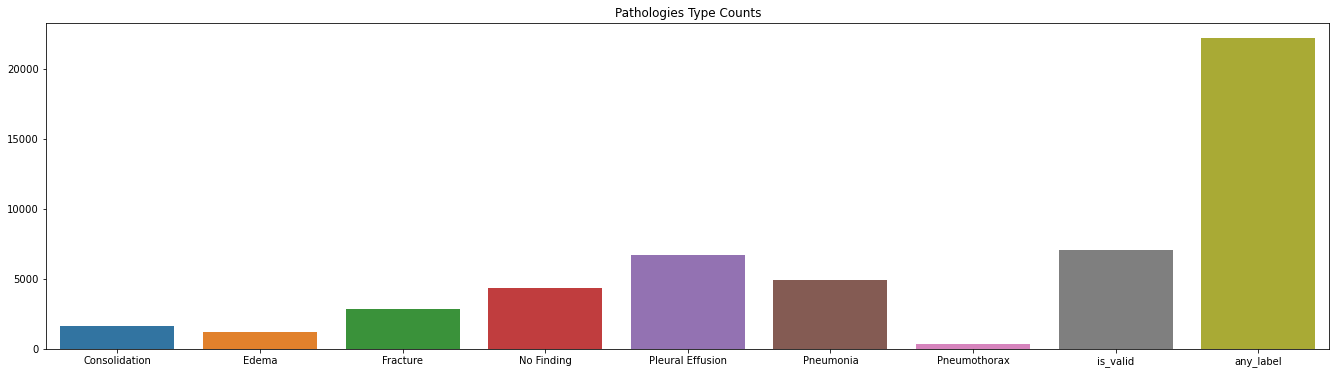

In [12]:
targets = list(df_labels.columns[4:13])
df_targets = df_labels[targets].copy()

# How many rows are postive? 
positive_rows = df_targets.sum(axis=1)
positive_rows = (positive_rows > 0)

# Create overall any_label feature
targets.append('any_label')
df_targets['any_label'] = positive_rows

count_dic = {}
for path_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[path_type]==1)]
    others.remove(path_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[path_type] = counts


del(df_selection)

def heatmap(df_labels, title):
    plt.figure('heatmap', figsize=[13,13])
    plt.title(title)
    df_corr = df_labels.corr()
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd')
    plt.yticks(rotation = 45)
    plt.xticks(rotation = 45)
    plt.show()

heatmap(df_targets, 'Pathologies Type Heatmap')


print('Pathologies Breakdown')
print('=====\n')

print('%d out of %d pathology, or %.2f%%, are classified as positive.' % 
     (np.sum(positive_rows), len(df_labels), (np.sum(positive_rows)/len(df_labels))*100))

totals = []
for key, value in count_dic.items():
    totals.append(value[0][1])
    print('\n%d %s pathology. (%.2f%% of all data.)' % (value[0][1], key, (value[0][1]/len(df_labels))*100))
    for cnt in value[1:]:
        print('- %d or %.2f%% were also %s.' % (cnt[1], (cnt[1]/value[0][1])*100, cnt[0]))
    

plt.figure('Pathologies Type Counts', figsize=[23,6])
plt.title('Pathologies Type Counts')
sns.barplot(x=list(count_dic.keys()), y=totals)
plt.show()

In [13]:
print(df_labels['Atelectasis'].value_counts())
print(df_labels['Cardiomegaly'].value_counts())
print(df_labels['Consolidation'].value_counts())
print(df_labels['Edema'].value_counts())
print(df_labels['Fracture'].value_counts())
print(df_labels['No Finding'].value_counts())
print(df_labels['Pleural Effusion'].value_counts())
print(df_labels['Pneumonia'].value_counts())
print(df_labels['Pneumothorax'].value_counts())

0    23493
1     5872
Name: Atelectasis, dtype: int64
0    21167
1     8198
Name: Cardiomegaly, dtype: int64
0    27763
1     1602
Name: Consolidation, dtype: int64
0    28125
1     1240
Name: Edema, dtype: int64
0    26513
1     2852
Name: Fracture, dtype: int64
0    25020
1     4345
Name: No Finding, dtype: int64
0    22652
1     6713
Name: Pleural Effusion, dtype: int64
0    24427
1     4938
Name: Pneumonia, dtype: int64
0    29023
1      342
Name: Pneumothorax, dtype: int64


In [14]:
print(df_train['Atelectasis'].value_counts())
print(df_train['Cardiomegaly'].value_counts())
print(df_train['Consolidation'].value_counts())
print(df_train['Edema'].value_counts())
print(df_train['Fracture'].value_counts())
print(df_train['No Finding'].value_counts())
print(df_train['Pleural Effusion'].value_counts())
print(df_train['Pneumonia'].value_counts())
print(df_train['Pneumothorax'].value_counts())

0    17874
1     4401
Name: Atelectasis, dtype: int64
0    16377
1     5898
Name: Cardiomegaly, dtype: int64
0    20905
1     1370
Name: Consolidation, dtype: int64
0    21106
1     1169
Name: Edema, dtype: int64
0    20174
1     2101
Name: Fracture, dtype: int64
0    19233
1     3042
Name: No Finding, dtype: int64
0    16755
1     5520
Name: Pleural Effusion, dtype: int64
0    18421
1     3854
Name: Pneumonia, dtype: int64
0    22000
1      275
Name: Pneumothorax, dtype: int64


In [15]:
print(df_test['Atelectasis'].value_counts())
print(df_test['Cardiomegaly'].value_counts())
print(df_test['Consolidation'].value_counts())
print(df_test['Edema'].value_counts())
print(df_test['Fracture'].value_counts())
print(df_test['No Finding'].value_counts())
print(df_test['Pleural Effusion'].value_counts())
print(df_test['Pneumonia'].value_counts())
print(df_test['Pneumothorax'].value_counts())

0    5619
1    1471
Name: Atelectasis, dtype: int64
0    4790
1    2300
Name: Cardiomegaly, dtype: int64
0    6858
1     232
Name: Consolidation, dtype: int64
0    7019
1      71
Name: Edema, dtype: int64
0    6339
1     751
Name: Fracture, dtype: int64
0    5787
1    1303
Name: No Finding, dtype: int64
0    5897
1    1193
Name: Pleural Effusion, dtype: int64
0    6006
1    1084
Name: Pneumonia, dtype: int64
0    7023
1      67
Name: Pneumothorax, dtype: int64
